In [11]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import RobustScaler, OneHotEncoder

In [12]:
from tensorflow.keras.utils import to_categorical

def import_and_clean_file(file, file_dir):
    # read data from name of file
    sensor, student, activity, activity_subtype, _, date, timestamp = file[:-4].split("_")
    # read in database
    df = pd.read_csv(file_dir)
    # drop features we dont want
    df = df.drop(['ind', 'mag_x','mag_y','mag_z', 'gyro_x','gyro_y','gyro_z'], axis = 1, errors = 'ignore')
    df['timestamp'] = df['timestamp'].astype(np.float64)
    df['activity'] = activity
    df['activity_subtype'] = activity_subtype
    df.sort_values(by=['timestamp'])
    
    return df

In [13]:
from scipy import stats

def get_X_y(directory='2023', window_size=25, overlap=10):
    # Initialize lists to store data and labels
    X = []  # Data
    y = []  # Labels

    # Loop through the clean-named subfolders
    for student in os.listdir(directory):
            if "placeholder" not in student:
                student_directory = os.path.join(directory, student)
                # itterate through students data
                for file in os.listdir(student_directory):
                    file_dir = os.path.join(student_directory, file)
                    if os.path.isfile(file_dir) and "clean" in file and "Respeck" in file:
                        sensor, student, activity, activity_subtype, _, date, timestamp = file[:-4].split("_")
                        df = import_and_clean_file(file, file_dir)
                        # Split the time series data into overlapping windows
                        for i in range(0, len(df) - window_size + 1, overlap):
                            window = df[i:i + window_size]
                            # create X matrix
                            X.append(window.drop(columns=['timestamp','activity', 'activity_subtype']))
                            # create y matrix
                            y.append(activity)

    return np.array(X), np.array(y).reshape(-1,1)

In [14]:
X, y = get_X_y()
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
print(X_train.shape, y_train.shape)

pd.DataFrame(X_train[0]).head()

(7819, 25, 3) (7819, 1)


,0,1,2
0,0.186768,0.019226,-0.940002
1,0.175537,0.024841,-0.949280
2,0.188965,0.034607,-0.961975
3,0.200928,0.006287,-1.013000
4,0.255127,-0.010803,-0.857727


In [15]:
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)

enc = enc.fit(y_train)
y_train = enc.transform(y_train)
enc = enc.fit(y_val)
y_val = enc.transform(y_val)

# enc = enc.fit(y_test)
# y_test = enc.transform(y_test)
print(X_train.shape, y_train.shape)

(7819, 25, 3) (7819, 12)


In [17]:
model = keras.Sequential()
model.add(keras.layers.Normalization())
model.add(
    keras.layers.Bidirectional(
      keras.layers.LSTM(
          units=128, 
          input_shape=[X_train.shape[1], X_train.shape[2]]
      )
    )
)
model.add(keras.layers.Dropout(rate=0.5))
model.add(keras.layers.Dense(units=128, activation='relu'))
model.add(keras.layers.Dense(y_train.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [18]:
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    shuffle=False
)

Epoch 1/50
220/220 [==============================] - 13s 43ms/step - loss: 0.8393 - accuracy: 0.7004 - val_loss: 0.6242 - val_accuracy: 0.7404
Epoch 2/50
220/220 [==============================] - 7s 31ms/step - loss: 0.6337 - accuracy: 0.7580 - val_loss: 0.5831 - val_accuracy: 0.7711
Epoch 3/50
220/220 [==============================] - 7s 33ms/step - loss: 0.5701 - accuracy: 0.7772 - val_loss: 0.5267 - val_accuracy: 0.7864
Epoch 4/50
220/220 [==============================] - 8s 35ms/step - loss: 0.5371 - accuracy: 0.7903 - val_loss: 0.5588 - val_accuracy: 0.7877
Epoch 5/50
220/220 [==============================] - 7s 32ms/step - loss: 0.5210 - accuracy: 0.8011 - val_loss: 0.5532 - val_accuracy: 0.7839
Epoch 6/50
220/220 [==============================] - 8s 37ms/step - loss: 0.5440 - accuracy: 0.7925 - val_loss: 0.5134 - val_accuracy: 0.7967
Epoch 7/50
220/220 [==============================] - 10s 46ms/step - loss: 0.4948 - accuracy: 0.8094 - val_loss: 0.5382 - val_accuracy: 0.78

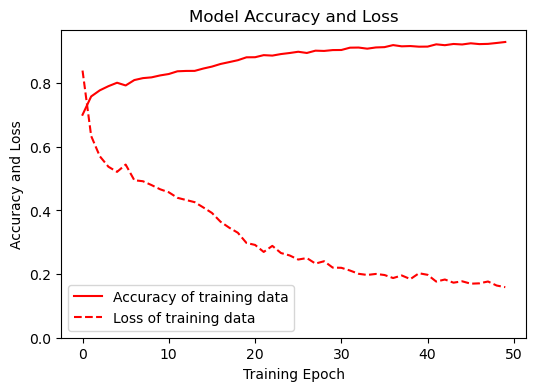

In [19]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], 'r', label='Accuracy of training data')
plt.plot(history.history['loss'], 'r--', label='Loss of training data')
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()



31/31 [==============================] - 1s 14ms/step


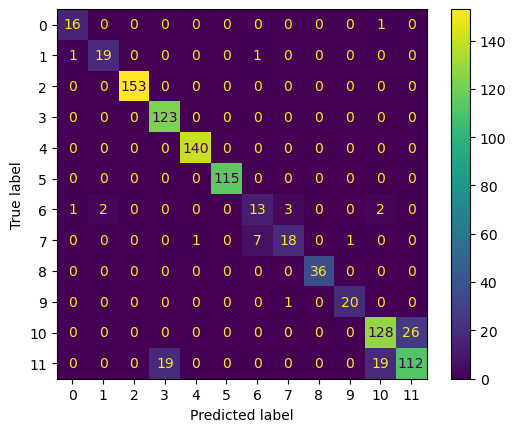

In [20]:
predictions = model.predict(X_val)
predictions = np.argmax(predictions, axis=1)
y_val_pred = np.argmax(y_val, axis=1)
cm = confusion_matrix(y_val_pred, predictions)
cm_disp = ConfusionMatrixDisplay(confusion_matrix= cm)
cm_disp.plot()
plt.show()

In [21]:
print(classification_report(y_val_pred, predictions))

              precision    recall  f1-score   support

           0       0.89      0.94      0.91        17
           1       0.90      0.90      0.90        21
           2       1.00      1.00      1.00       153
           3       0.87      1.00      0.93       123
           4       0.99      1.00      1.00       140
           5       1.00      1.00      1.00       115
           6       0.62      0.62      0.62        21
           7       0.82      0.67      0.73        27
           8       1.00      1.00      1.00        36
           9       0.95      0.95      0.95        21
          10       0.85      0.83      0.84       154
          11       0.81      0.75      0.78       150

    accuracy                           0.91       978
   macro avg       0.89      0.89      0.89       978
weighted avg       0.91      0.91      0.91       978



In [22]:
model.evaluate(X_val, y_val)

31/31 [==============================] - 0s 12ms/step - loss: 0.1934 - accuracy: 0.9131


[0.19335660338401794, 0.9130879640579224]

In [23]:
[name[3:] for name in enc.get_feature_names_out()]

['Ascending stairs',
 'Descending stairs',
 'Lying down back',
 'Lying down on left',
 'Lying down on stomach',
 'Lying down right',
 'Miscellaneous movements',
 'Normal walking',
 'Running',
 'Shuffle walking',
 'Sitting',
 'Standing']

In [24]:

# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
converter._experimental_lower_tensor_list_ops = False
tflite_model = converter.convert()

# Save the model.
with open('C:/Users/Public/model.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpucz6aybi/assets


INFO:tensorflow:Assets written to: /tmp/tmpucz6aybi/assets
2023-10-19 14:51:47.267451: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2023-10-19 14:51:47.267488: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2023-10-19 14:51:47.268391: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpucz6aybi
2023-10-19 14:51:47.292241: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2023-10-19 14:51:47.292464: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpucz6aybi
2023-10-19 14:51:47.311409: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2023-10-19 14:51:47.363146: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is n

FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/Public/model.tflite'